In [1]:
import openai
import wandb
from pathlib import Path
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

In [27]:
!openai wandb sync


🎉 wandb sync completed successfully


wandb: Currently logged in as: ghosh-11. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.2
wandb: Run data is saved locally in g:\MTechClasses\DL-Ops\Project\hate-speech-detection\notebooks\wandb\run-20230513_111953-ft-v6g0Kid5b6R8xO5LiylaTmDv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-v6g0Kid5b6R8xO5LiylaTmDv
wandb:  View project at https://wandb.ai/ghosh-11/GPT-3
wandb:  View run at https://wandb.ai/ghosh-11/GPT-3/runs/ft-v6g0Kid5b6R8xO5LiylaTmDv
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:             elapsed_examples ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:               elapsed_tokens ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                training_loss █▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
wandb:   training_sequence_accuracy ▁▅▅▁██▅▅██▅▅█▅▁▅▅▁▅█▅▅█▅▅███▅██▅█▅█▅█▅▅▅
wandb:      training_token_accuracy ▁▆▇▆██▇▇██▇▇█▇▅▇▆▅▇█▆▇█▇▇███▇██▇█▇█▆█▇▅▇
wandb:     

In [6]:
import pandas as pd
import os

file_types = ['trn', 'dev', 'tst']
for f in file_types:
    src_data_df = pd.read_csv(f'../data/SBIC.v2.agg.{f}.csv').sample(frac=0.05)
    result_df = pd.DataFrame()
    # print(src_data_df.sample(2))
    result_df['prompt'] = src_data_df['post'].apply(
        lambda x: str(x)+'\n\n###\n\n')
    result_df['completion'] = src_data_df.apply(
        lambda x: f''' { 'offY' if x['offensiveYN'] > 0.5 else 'offN'}\n{ 'biasY' if x['hasBiasedImplication'] > 0.5 else 'biasN'}''', axis=1)

    result_df.to_json(
        f'../data/SBIC.v2.agg.{f}.tiny.social-bias.promted_prepared.jsonl', orient='records', lines=True)
    print(
        f'openai tools fine_tunes.prepare_data -f data/SBIC.v2.agg.{f}.tiny.social-bias.promted_prepared.jsonl')

openai tools fine_tunes.prepare_data -f data/SBIC.v2.agg.trn.tiny.social-bias.promted_prepared.jsonl
openai tools fine_tunes.prepare_data -f data/SBIC.v2.agg.dev.tiny.social-bias.promted_prepared.jsonl
openai tools fine_tunes.prepare_data -f data/SBIC.v2.agg.tst.tiny.social-bias.promted_prepared.jsonl


In [4]:
!openai tools fine_tunes.prepare_data -f data/SBIC.v2.agg.dev.tiny.social-bias.promted_prepared.jsonl


^C


In [ ]:
!openai api fine_tunes.create - t "data/SBIC.v2.agg.trn.tiny.social-bias.promted_prepared.jsonl" - v "data/SBIC.v2.agg.dev.tiny.social-bias.promted_prepared.jsonl" -m curie --n_epochs 2 --learning_rate_multiplier 0.05


In [7]:
curl https://api.openai.com/v1/fine-tunes/ft-v6g0Kid5b6R8xO5LiylaTmDv -H "Authorization: Bearer $OPENAI_API_KEY" > results/fine-tuned-curie-social-bias.json 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   245  100   245    0     0    342      0 --:--:-- --:--:-- --:--:--   342
100   245  100   245    0     0    342      0 --:--:-- --:--:-- --:--:--   342


In [6]:
!openai api fine_tunes.results -i ft-v6g0Kid5b6R8xO5LiylaTmDv > results/result-social-bias.csv 


Error: No results file available for fine-tune ft-HGqkTToaXFMc4RUPlhTyYlbH


In [10]:
results = pd.read_csv('../results/result-social-bias.csv')
results

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy
0,1,50,2,2.914429,0.0,0.000000,1.393313,0.0,0.0
1,2,180,4,1.101520,0.0,0.000000,NaN,NaN,NaN
2,3,262,6,1.719421,0.0,0.000000,NaN,NaN,NaN
3,4,344,8,1.645779,0.0,0.000000,NaN,NaN,NaN
4,5,442,10,1.364400,0.0,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1767,1768,174240,3536,0.065788,0.5,0.916667,NaN,NaN,NaN
1768,1769,174338,3538,0.023977,1.0,1.000000,0.025706,1.0,1.0
1769,1770,174436,3540,0.032578,1.0,1.000000,NaN,NaN,NaN
1770,1771,174614,3542,0.029821,0.5,0.833333,NaN,NaN,NaN


<AxesSubplot:>

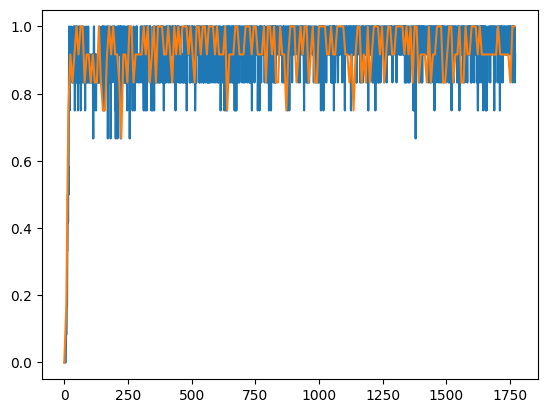

In [15]:
results[results['training_token_accuracy'].notnull()]['training_token_accuracy'].plot()
results[results['validation_token_accuracy'].notnull()]['validation_token_accuracy'].plot()

<AxesSubplot:>

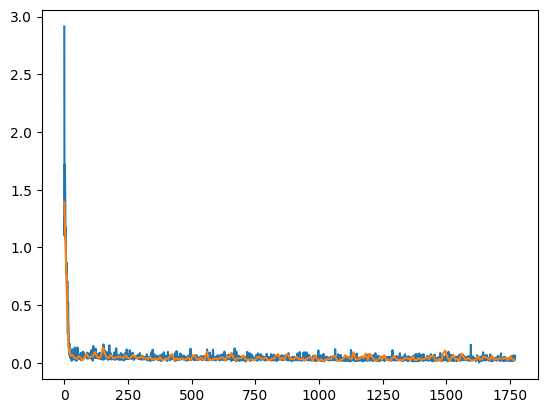

In [16]:

results[results['training_loss'].notnull()]['training_loss'].plot()
results[results['validation_loss'].notnull()]['validation_loss'].plot()

Using the model

In [18]:
test = pd.read_json(
    '../data/SBIC.v2.agg.tst.tiny.social-bias.promted_prepared.jsonl', orient='records', lines=True)
test.head()


,prompt,completion
0,what do you do after getting the thightiest pu...,offY\nbiasN
1,Four-year-old boy:: Why did she get to walk in...,offY\nbiasN
2,"""@Vodkantots I refer to them as, """"fucknutz""""....",offY\nbiasY
3,Broken Dishwasher Husband: The dishwasher is b...,offY\nbiasN
4,"The fly on the wall,\nBy the stairs, down the ...",offN\nbiasY


In [31]:

import openai
ft_model = 'curie:ft-personal-2023-05-13-05-29-59'


def inferGPT3FineTuned(input):
    res = openai.Completion.create(
        model=ft_model, prompt=input, max_tokens=6, temperature=0)
    return res['choices'][0]['text']


inferGPT3FineTuned(test['prompt'][2])


' offY\nbiasY'

In [25]:
print(test['prompt'][2])
res = openai.Completion.create(
    model=ft_model, prompt=test['prompt'][2], max_tokens=4, temperature=0, logprobs=4)
res['choices'][0]['logprobs']['top_logprobs'][0]


"@Vodkantots I refer to them as, ""fucknutz"". As in, ""hey fucknutz it's a 4-way. Fucking go, now!"""

###




<OpenAIObject at 0x15b7225e160> JSON: {
  " Off": -17.418987,
  " after": -17.47779,
  " off": -1.8841804e-07,
  "off": -16.520105
}

In [35]:
from sklearn import metrics
import seaborn as sns
# sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})
import pandas as pd
import matplotlib.pyplot as plt
import time


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    # plt.show()
    plt.savefig(
        f'../results/confusion_mat_{title}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())
    #wandb.log({"accuracy_score": overallAccuracy, "f1_score": f1_score, })


In [28]:
test

,prompt,completion
0,what do you do after getting the thightiest pu...,offY\nbiasN
1,Four-year-old boy:: Why did she get to walk in...,offY\nbiasN
2,"""@Vodkantots I refer to them as, """"fucknutz""""....",offY\nbiasY
3,Broken Dishwasher Husband: The dishwasher is b...,offY\nbiasN
4,"The fly on the wall,\nBy the stairs, down the ...",offN\nbiasY
...,...,...
230,At the time Robert Mugabe ordered his thugs to...,offN\nbiasY
231,Funny how they cant send someone to get pics o...,offN\nbiasY
232,Shower Quest: write down the last time you've ...,offN\nbiasY
233,"My World, My Happiness, My Sunshine, My Star, ...",offN\nbiasY


In [32]:

predicted = []
for row in test.values:
    predicted.append(inferGPT3FineTuned(row[0]))


In [33]:
print(metrics.classification_report(test['completion'].values, predicted))


              precision    recall  f1-score   support

  offN
biasN       0.00      0.00      0.00         3
  offN
biasY       0.78      0.81      0.79       113
  offY
biasN       0.75      0.79      0.77        95
  offY
biasY       0.37      0.29      0.33        24

    accuracy                           0.74       235
   macro avg       0.48      0.47      0.47       235
weighted avg       0.72      0.74      0.73       235



c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 73.617%
F1 Score: 72.638%

Classwise Accuracy Score: 
|   Non-Hate+Non-Biased |   Non-Hate+Biased |   Hate+Non-Biased |   Hate+Biased |
|----------------------:|------------------:|------------------:|--------------:|
|                     0 |           0.80531 |          0.789474 |      0.291667 |

Confusion Matrix:
| True Label          |   Non-Hate+Non-Biased |   Non-Hate+Biased |   Hate+Non-Biased |   Hate+Biased |
|:--------------------|----------------------:|------------------:|------------------:|--------------:|
| Non-Hate+Non-Biased |                     0 |                 1 |                 2 |             0 |
| Non-Hate+Biased     |                     0 |                91 |                16 |             6 |
| Hate+Non-Biased     |                     0 |                14 |                75 |             6 |
| Hate+Biased         |                     0 |                10 |                 7 |             7 |


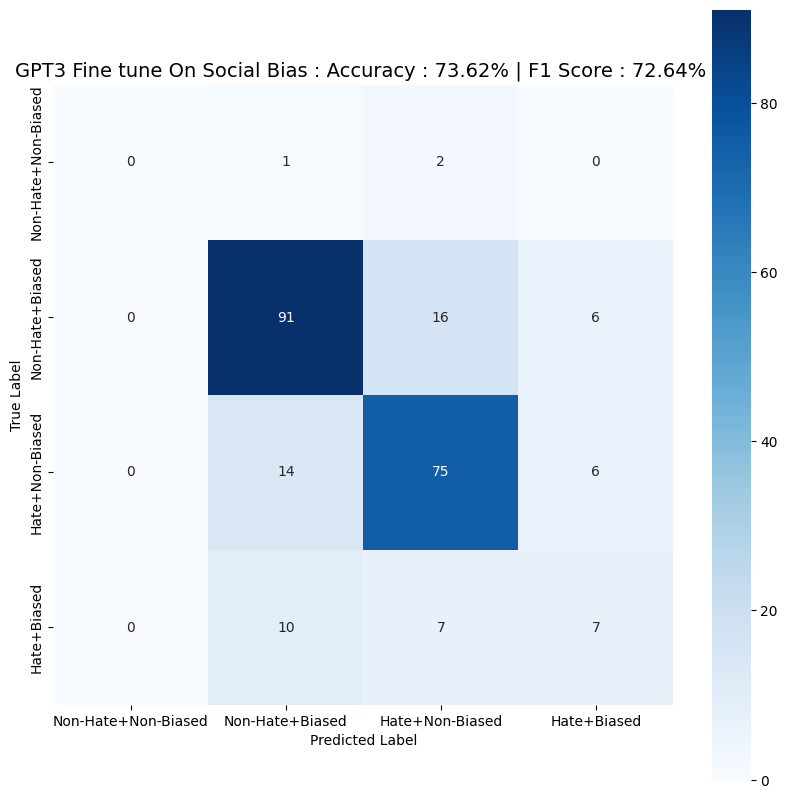

In [36]:

confusionMatrixAndAccuracyReport(test['completion'].values, predicted, [
                                 'Non-Hate+Non-Biased', 'Non-Hate+Biased', 'Hate+Non-Biased', 'Hate+Biased',], title='GPT3 Fine tune On Social Bias')

In [37]:
predicted_df = pd.DataFrame({'actual':test['completion'],'predicted':predicted})
predicted_df

,actual,predicted
0,offY\nbiasN,offY\nbiasY
1,offY\nbiasN,offY\nbiasN
2,offY\nbiasY,offY\nbiasY
3,offY\nbiasN,offN\nbiasY
4,offN\nbiasY,offN\nbiasY
...,...,...
230,offN\nbiasY,offY\nbiasN
231,offN\nbiasY,offY\nbiasN
232,offN\nbiasY,offN\nbiasY
233,offN\nbiasY,offN\nbiasY


In [ ]:
predicted_df.to_csv('../data/predicted_social_b_curie_SBIC.v2.agg.tst.tiny.csv',index=False)